## Import Tools

In [1]:
import urllib
url = "https://raw.githubusercontent.com/Jwizzed/ml-journey/main/TTCV.py"
urllib.request.urlretrieve(url, "TTCV.py")
import TTCV

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import os
import TTCV

In [3]:
TTCV.info()

+-----------------------+----------------------------------------------------------+
| Function              | Description                                              |
+=======================+==========================================================+
| report_dir            | Walks through dir_path returning its contents            |
+-----------------------+----------------------------------------------------------+
| unzip                 | Unzips a file                                            |
+-----------------------+----------------------------------------------------------+
| get_lines             | Read the contents of the file and return them as a list  |
+-----------------------+----------------------------------------------------------+
| view_random_image     | Visualize the difference in shape between two DataFrames |
+-----------------------+----------------------------------------------------------+
| get_train_time        | Gets difference between start and end t

In [4]:
np.random.seed(224)

In [5]:
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# device
device = 'cpu'
device

'cpu'

## Get a data

In [6]:
!kaggle competitions download -c dog-breed-identification

100%|███████████████████████████████████████▊| 688M/691M [00:35<00:00, 21.2MB/s]
100%|████████████████████████████████████████| 691M/691M [00:35<00:00, 20.6MB/s]


In [7]:
!unzip dog-breed-identification.zip
# !rm dog-breed-identification.zip

Archive:  dog-breed-identification.zip
replace labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [8]:
!ls

Dog_Breed_Identification.ipynb model_20231004_132619_1
TTCV.py                        runs
__pycache__                    sample_submission.csv
dog-breed-identification.zip   test
labels.csv                     train
model_20231004_132619_0


In [9]:
INPUT_SIZE = 224
NUM_CLASSES = 120
data_dir = ''
labels = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

print(f"Train: {len(os.listdir(os.path.join(data_dir, 'train')))} files")
print(f"Label: {len(labels)} files")
print(f"Test: {len(os.listdir(os.path.join(data_dir, 'test')))} files")
print(f"Submission: {len(sample_submission)} files")

Train: 10222 files
Label: 10222 files
Test: 10357 files
Submission: 10357 files


In [10]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Data Preprocessing

Turn the `breed` column into an integer (CrossEntropyLoss expects integers)

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels.breed = label_encoder.fit_transform(labels.breed)
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


In [12]:
len(labels.breed.unique())

120

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train, val = train_test_split(labels, test_size=0.2)
print(len(train), len(val))

8177 2045


In [15]:
class CustomDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.image_paths = self.df[["id"]]
        self.labels = self.df[["breed"]]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.data_dir+"/"+self.image_paths.iloc[idx].id+".jpg"
        label = self.labels.iloc[idx].breed
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [16]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = CustomDataset(train, data_dir="train", transform=ds_trans)
valid_ds = CustomDataset(val, data_dir="train", transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4)
valid_dl = DataLoader(valid_ds, batch_size=4)

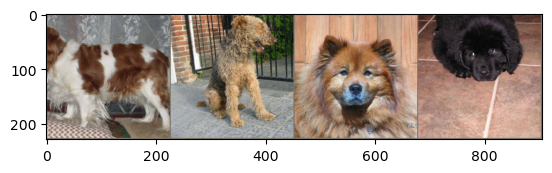

In [18]:
from torchvision.utils import make_grid
def imshow(img):
    npimg = img.numpy()
    mean = np.array([0.485, 0.456, 0.406])[:, None, None]
    std = np.array([0.229, 0.224, 0.225])[:, None, None]
    npimg = std * npimg + mean
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_dl))
imshow(make_grid(images))


## Get a model

In [19]:
model = models.resnet50(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)

/Users/krittinsetdhavanich/pytorch-test/torch_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/krittinsetdhavanich/pytorch-test/torch_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
images, labels = next(iter(train_dl))
images, labels = images.to(device), labels.to(device)
output = model(images)
output, output.size()

(tensor([[-4.1044e-02, -3.3166e-01,  8.2048e-02,  2.3411e-01,  1.4055e-01,
           5.0679e-01, -1.9403e-01,  3.4938e-01,  3.0467e-01, -3.8371e-01,
           2.4825e-01,  3.0828e-01,  3.6486e-02, -6.0918e-02, -1.5370e-01,
          -4.0436e-01,  2.9514e-01,  4.3656e-01,  4.4070e-01,  2.6120e-01,
           5.5783e-02,  3.3693e-01,  2.4205e-01, -4.5551e-01,  1.9878e-01,
          -1.3977e-01, -2.1452e-01,  5.1219e-01, -3.3020e-01, -2.5043e-01,
           3.6995e-01, -4.4603e-01, -1.8970e-01,  1.0116e-01,  3.0110e-01,
           2.8289e-01, -2.5673e-01,  1.8339e-01,  5.7546e-01, -1.6031e-02,
          -5.2000e-01, -3.6314e-01, -7.9183e-02,  1.2820e-01, -4.3043e-01,
           4.7312e-01, -3.4421e-01,  2.3358e-01, -4.8538e-01, -3.1145e-01,
          -4.4674e-02, -2.0125e-02,  5.0527e-01, -5.0929e-02,  1.5715e-01,
           4.1207e-01, -1.8992e-01, -6.4218e-02,  1.1335e-01, -6.5126e-02,
          -6.5974e-02,  3.1192e-01,  5.9086e-01, -3.1639e-01, -4.2792e-01,
           4.4009e-02, -2

In [21]:
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

In [22]:
def train_one_epoch(epoch_index, tb_writer, dl):
    """https://pytorch.org/tutorials/beginner/introyt/trainingyt.html"""
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(dl):
        # Every data instance is an input + label pair
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Make predictions for this batch
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(dl) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [23]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, train_dl)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(valid_dl):
            vinputs, vlabels = vdata
            vinputs, vlabels =vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 3.8784946398735047
  batch 2000 loss: 2.547045088112354
LOSS train 2.547045088112354 valid 1.062224268913269
EPOCH 2:
  batch 1000 loss: 1.73589713793993
  batch 2000 loss: 1.5755908466875552
LOSS train 1.5755908466875552 valid 0.7125892639160156
EPOCH 3:
  batch 1000 loss: 1.2463494088351728
  batch 2000 loss: 1.2447303966730834
LOSS train 1.2447303966730834 valid 0.6315731406211853
EPOCH 4:
  batch 1000 loss: 1.0335453792586922
  batch 2000 loss: 1.0643000931963325
LOSS train 1.0643000931963325 valid 0.6028410792350769
EPOCH 5:
  batch 1000 loss: 0.9042543634846807
  batch 2000 loss: 0.9423422324471176
LOSS train 0.9423422324471176 valid 0.5917096734046936
